In [1]:
import glob
import csv
from tqdm.notebook import tqdm
import numpy as np
import functools

from utils.featurize import normalize, t_featurize, select_features
from utils.symbolic import get_all_logprobs, get_exp_featurize, backtrack_functions
from utils.load import Dataset, get_generate_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import pickle
import random
import plotly.express as px
import torch
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os
%matplotlib inline

/Users/leo/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/leo/.pyenv/versions/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
exp_to_data = pickle.load(open("symbolic_data_baseline", "rb"))
t_data = pickle.load(open("t_data_baseline", "rb"))

exp_to_data_eval = pickle.load(open("symbolic_data_eval", "rb"))
t_data_eval = pickle.load(open("t_data_eval", "rb"))

In [3]:
def get_featurized_data(best_features, gpt_only=False):
    gpt_data = np.concatenate(
        [t_data] + [exp_to_data[i] for i in best_features if i in exp_to_data.keys()], axis=1
    )
    if gpt_only:
        return gpt_data

    eval_data = np.concatenate(
        [t_data_eval] + [exp_to_data_eval[i] for i in best_features], axis=1
    )
    return np.concatenate([gpt_data, eval_data], axis=0)

In [4]:
def get_featurized_aug(best_features, aug_t_data, aug_exp, gpt_only=False):
    gpt_data = np.concatenate(
        [aug_t_data] + [aug_exp[i] for i in best_features if i in aug_exp.keys()], axis=1
    )

    return gpt_data

# Data loading

In [5]:
file_retriever = lambda past, model: past + glob.glob(f"{base_path}/{model}/*.txt")
base_path = "data/essay"

In [6]:
train_models = ["human", "gpt"]
train_files = sorted(functools.reduce(file_retriever, train_models, []), key=lambda x: int(x.split("/")[-1].split(".")[0]))

In [7]:
test_models = ["gpt_prompt1", "gpt_prompt2", "gpt_semantic", "gpt_writing", "claude"]
test_files = sorted(functools.reduce(file_retriever, test_models, []), key=lambda x: int(x.split("/")[-1].split(".")[0]))

In [8]:
print(f"Num train: {len(train_files)}")
print(f"Num test: {len(test_files)}")

Num train: 1988
Num test: 4970


In [9]:
all_files = train_files + test_files
print(f"All files length: {len(all_files)}")

All files length: 6958


# Splitting Data

In [10]:
class config:
    p = 0.1

In [11]:
train_labels = np.array(["human" not in file for file in train_files]).astype(int)
test_labels = np.array(["human" not in file for file in test_files]).astype(int)
all_labels = np.concatenate((train_labels, test_labels))

print(f"All labels length: {len(all_labels)}")

All labels length: 6958


In [12]:
other_test_indices = np.arange(len(all_labels))[1988:]
augmentations = ["baseline", "synonym", "back", "emotion", "style", "summary"]
train_sizes = [10, 25, 50, 75, 100]
seeds = list(range(51, 100))
score_dict = {}

**************** SEED 51 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 273.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 237.44it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8745725113226731

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.53it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.01it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9589539314166955

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.03it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9794238683127572

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.52it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.992024435771254

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.09it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div ada-logprobs v-mul davinci-logprobs s-len, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 206.14it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9790593889461037

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.9013806706114399

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.88it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9669952850407201

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.34it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.22it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9638847793925681

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9771084337349397

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.19it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9833904109589041

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.91it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.31it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.9240484125592001

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9633011716057891

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.20it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.58it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9625948208213445

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9645909645909646

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.16it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9728373702422145

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.70it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8929536853487114

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.61it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9661395668614644

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.08it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9642639770454743

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.17it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9813068084376608

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.25it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.70it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9839965768078733

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.75it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8891918916462139

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9679075738125802

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.15it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9637946040034813

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.44it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.963001745200698

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.05it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9760344827586207

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.53it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.08it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.8800367985280588

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.52it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.88it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9688356164383561

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.57it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9610185750414232

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.05it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9579140782220666

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9814814814814815

passes...


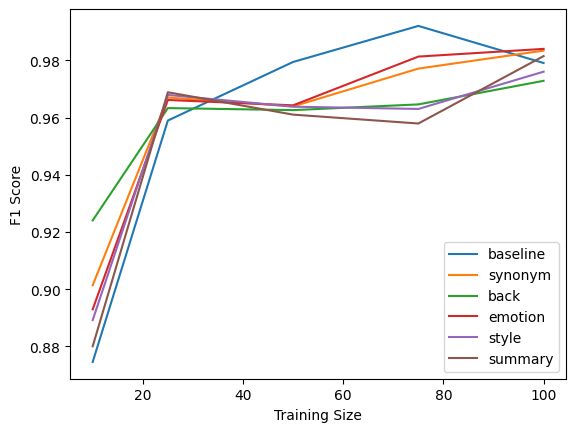

**************** SEED 52 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 241.53it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9095034945992557

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div trigram-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.11it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.989990747750021

early stopping.
early stopping
**************** SEED 53 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.84it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.7395471300684571

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.95it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div ada-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9460529789668222

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.57it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.30it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-add davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 203.40it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs v-add davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.966241430183112

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.03it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.25it/s]


Iteration 1, Current Score: 0.9866666667,                 Best Feature: davinci-logprobs s-len, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 209.01it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9936413734633319

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.94it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.58it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9883414177516807

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.53it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.6680040120361084

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.89it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9678089304257529

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.72it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.97it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 209.05it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9442570566305698

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.02it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.976932346359098

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.05it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9726312142733414

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.14it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.5819477434679335

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 270.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.32it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.969057908383751

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.49it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 207.41it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9504146814893242

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.08it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.982726184368052

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 244.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.12it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.983196159122085

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.13it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.74it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.6029222676797195

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.67it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9650325379609545

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.69it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.86it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 207.40it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9392777530093624

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.32it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9814228233884085

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.59it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.91it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9735202492211839

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 235.07it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.6632367744100213

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.10it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9555010511562719

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.66it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 206.76it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9385933595144591

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.56it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.984492160872529

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.50it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.87it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9815529815529815

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.00it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.67it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.5614161849710982

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.61it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9687905247687386

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.11it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 206.09it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9462117855560479

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.985618245255723

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9671075530804037

passes...


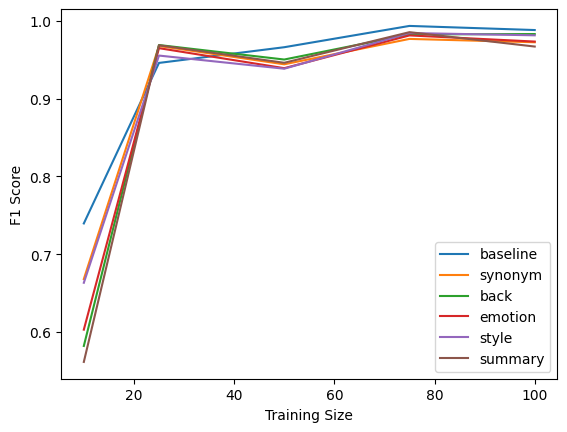

**************** SEED 54 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.17it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8077334110560576

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.16it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9926896899420217

early stopping.
early stopping
**************** SEED 55 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.58it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9508338373801088

early stopping.
early stopping
**************** SEED 56 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.94it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-> davinci-logprobs v-div trigram-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.823340874811463

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.77it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9875476493011436

early stopping.
early stopping
**************** SEED 57 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.41it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.65it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9839010337230978

early stopping.
early stopping
**************** SEED 58 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.6800176056338029

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.68it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9803888130968622

early stopping.
early stopping
**************** SEED 59 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.57it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.53it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9462586783234764

early stopping.
early stopping
**************** SEED 60 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.14it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.823126589708472

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.89it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.18it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9874399393070893

early stopping.
early stopping
**************** SEED 61 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.60it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.30it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9837011884550085

early stopping.
early stopping
**************** SEED 62 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.58it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.98it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8583295711060948

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.40it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9507651945780499

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.71it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.99561846983485

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.20it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.9866666667


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.21it/s]


Iteration 1, Current Score: 0.9866666667,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 204.43it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.989441416893733

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.89it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9883334752618581

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.91it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.81it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8753880266075388

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.50it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9546647995799055

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.44it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9904972000678771

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9884018420603786

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.67it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.984916009598903

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.73it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.861643712305338

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.16it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9640936686903729

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.20it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.78it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9885194319244833

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.64it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.48it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9831147681494814

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.77it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9856139749957185

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 235.20it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8630235484450836

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.15it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9693103448275862

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.53it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.74it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9883473675257294

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 253.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9841677364142063

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.77it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.75it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9830799622090527

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 234.34it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8622582096266307

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.72it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.76it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.923353724361281

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.80it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.78it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9811547027582662

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.69it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9742615304888582

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.81it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9819432502149613

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-add davinci-logprobs s-l2, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.45it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.9005163511187607

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.72it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9085254299304794

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9694504543487668

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.58it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.29it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9841704457944724

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9843039711810618

passes...


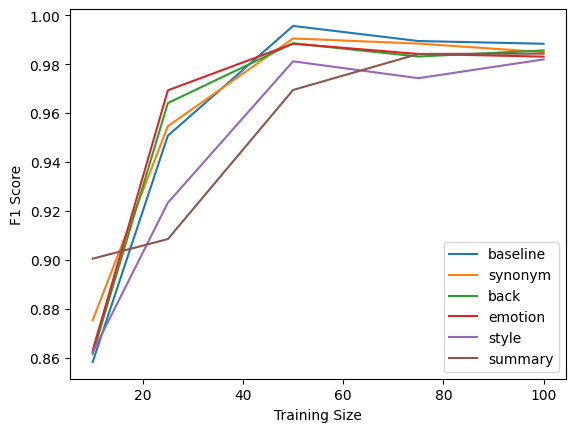

**************** SEED 63 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.07it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9825813578044014

early stopping.
early stopping
**************** SEED 64 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 238.57it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9764924742093691

early stopping.
early stopping
**************** SEED 65 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.63it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9811796336750126

early stopping.
early stopping
**************** SEED 66 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.28it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.14it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9459273290855864

early stopping.
early stopping
**************** SEED 67 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8098099084014577

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.94it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.56it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9374944899938288

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.41it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 0.98


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.72it/s]


Iteration 1, Current Score: 0.98,                 Best Feature: davinci-logprobs s-max, New Score: 0.98
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9725118483412323

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.40it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9923586347427407

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 196.80it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9584647739221872

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8608261974216618

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.75it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9320888888888889

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.76it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9765290388898407

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.12it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9842082799829279

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.03it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9880444064901793

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.22it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.8624577226606539

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.69it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9168620378719567

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9735888140859659

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.30it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9833319087101462

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.80it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.25it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9824832560535807

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.08it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8133163114995581

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.24it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9489804848166623

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.22it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9765524349394485

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.85it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9869314324507807

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.41it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.52it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9842141386410432

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.75it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.67it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8144370341310317

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.34it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.56it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9403471671512909

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.14it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.91it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9789779524867545

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.85it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9813707058622457

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.82it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.86it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9819711538461539

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.73it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.01it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.8582454819277109

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.00it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9403063919704173

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.34it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.55it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9752122823569774

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.57it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.987326698987837

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.58it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.63it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9794933655006032

passes...


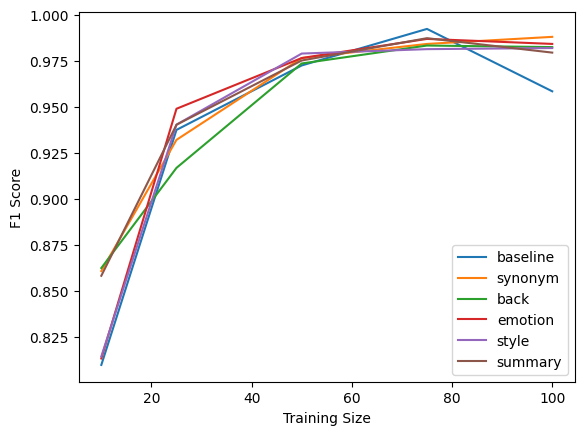

**************** SEED 68 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.54it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.82it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9480542043085476

early stopping.
early stopping
**************** SEED 69 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.47it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9192345701194862

early stopping.
early stopping
**************** SEED 70 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.52it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-add ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.6959083469721767

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.52it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9873974456567707

early stopping.
early stopping
**************** SEED 71 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.54it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 236.68it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9875240726785565

early stopping.
early stopping
**************** SEED 72 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-mul davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.00it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9228160970821808

early stopping.
early stopping
**************** SEED 73 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.69it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9799109019080441

early stopping.
early stopping
**************** SEED 74 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs v-add davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.16it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8716702663786897

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.89it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.08it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.976672384219554

early stopping.
early stopping
**************** SEED 75 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-sub davinci-logprobs v-div ada-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.94it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8860117225089669

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div unigram-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.42it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9863865546218488

early stopping.
early stopping
**************** SEED 76 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.63it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 235.39it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9672664952870609

early stopping.
early stopping
**************** SEED 77 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8301996510951735

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9401799894123875

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.50it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9865988125530111

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.19it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9867098313170898

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs v-div trigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.29it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9820554649265906

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.12it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.78it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8023036441267004

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.06it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9782775364170713

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.54it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9837211284411489

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.11it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.96it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9831494311863826

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.49it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 206.63it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.980179248534988

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 271.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.8131457246875923

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.69it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.04it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9617845408957288

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.74it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.47it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9836261299675934

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.73it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.9866234983385874

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.53it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 210.25it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.971224897852734

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 269.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8067789930042368

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.22it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.00it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9689909199931471

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.10it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9872643912379012

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.20it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.49it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9814005314133882

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.21it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 210.03it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9758587868824089

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.98it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.7856639484546462

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.06it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9639113249699262

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9860473030457717

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.24it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9800892550635084

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.83it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.86it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 208.62it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9679163034001743

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 269.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.60it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.8182262638114794

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.51it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs v-div unigram-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.72it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9488566940129167

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.00it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.63it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9809004092769441

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.59it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.983074029748675

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.36it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 207.41it/s]


Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9621119101911946

passes...


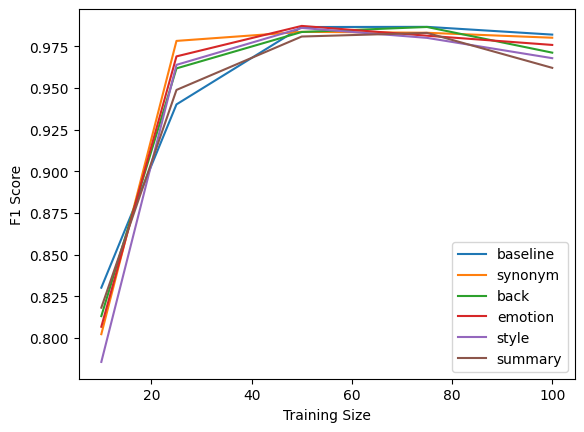

**************** SEED 78 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.7894736842105263

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.85it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.02it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9415988092111024

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9766363167840577

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9851129363449692

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.48it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9817558886509636

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.11it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.801152202192901

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-sub davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.79it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.7285982087065195

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.45it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.01it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9826658696951583

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.94it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.31it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9835503769705277

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.44it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9828414550446122

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.36it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.21it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.7919274969634682

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-sub davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.33it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.6986036519871106

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.41it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9741602067183462

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 251.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 201.94it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.98486273839049

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.61it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.42it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9770333275772751

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.66it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 226.91it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.7948192322027581

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-sub davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.7043366801965392

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.76it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9831115660184238

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 250.64it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.38it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9838143358739402

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.47it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9829257829257829

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.45it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.7961670853102614

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.30it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-sub davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.40it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.7762351980400163

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.62it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.08it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9824950900862437

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 248.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.39it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9819897084048027

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.14it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9788847711798673

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.77it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-> ada-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.34it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.7901535005615874

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-sub davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.93it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.6967044840626688

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.51it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.27it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9781284844326271

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.25it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9749524961133184

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.00it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 203.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9812714776632302

passes...


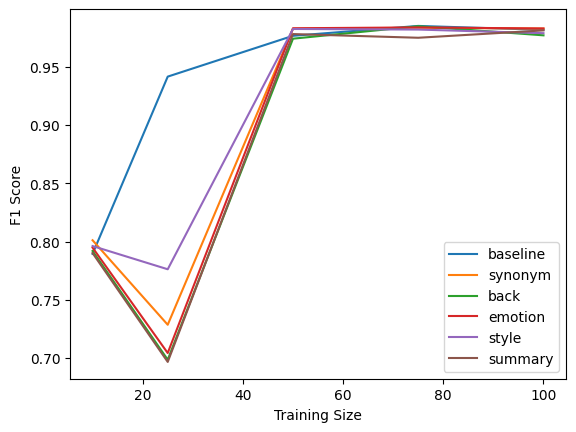

**************** SEED 79 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.26it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.85it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9878849066128218

early stopping.
early stopping
**************** SEED 80 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.94it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9884189325276939

early stopping.
early stopping
**************** SEED 81 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-div unigram-logprobs v-sub trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs v-div ada-logprobs s-avg-top-25, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8534232462302145

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.07it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9841269841269841

early stopping.
early stopping
**************** SEED 82 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.45it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9760108502161566

early stopping.
early stopping
**************** SEED 83 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.64it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.6012813046010483

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.49it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9888456988338685

early stopping.
early stopping
**************** SEED 84 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.24it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.32it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.969534823509105

early stopping.
early stopping
**************** SEED 85 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.35it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.695281712642454

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.92it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.63it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9883485309017224

early stopping.
early stopping
**************** SEED 86 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.07it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.36it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8398367036931549

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.44it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9621826972888966

early stopping.
early stopping
**************** SEED 87 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 236.86it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9613306315433975

early stopping.
early stopping
**************** SEED 88 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.88it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.43it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9525127584119021

early stopping.
early stopping
**************** SEED 89 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.18it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.64it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9764784946236559

early stopping.
early stopping
**************** SEED 90 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.09it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div trigram-logprobs v-add davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.37it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8031103578905393

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.42it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 222.30it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9855878634639696

early stopping.
early stopping
**************** SEED 91 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.01it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9924913524002362

early stopping.
early stopping
**************** SEED 92 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.54it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 235.22it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.953245181920318

early stopping.
early stopping
**************** SEED 93 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 230.70it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8980957282552754

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 215.82it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-var, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9543755974624142

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.82it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.09it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9881235154394299

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 249.89it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.27it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9878328937292606

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.69it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-add trigram-logprobs v-> davinci-logprobs s-var, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.33it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9920081618772317

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.34it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 228.80it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.8724808589281

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.96it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div trigram-logprobs s-avg, New Score: 0.96


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.34it/s]


Iteration 1, Current Score: 0.96,                 Best Feature: davinci-logprobs s-max, New Score: 0.96
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9633154525004326

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.05it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.61it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.974429616874731

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.74it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.86it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9860044376173408

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.70it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.98it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9836766088368516

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.66it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.8810919590515356

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 262.78it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div trigram-logprobs s-avg, New Score: 0.96


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.00it/s]


Iteration 1, Current Score: 0.96,                 Best Feature: davinci-logprobs s-max, New Score: 0.96
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9390567037625861

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 254.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9593084177436255

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 247.22it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.983027601577233

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.90it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.64it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9867075664621677

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.47it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.8693181818181818

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.60it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div trigram-logprobs s-avg, New Score: 0.96


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 220.49it/s]


Iteration 1, Current Score: 0.96,                 Best Feature: davinci-logprobs s-max, New Score: 0.96
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9660181582360571

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 253.43it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 212.54it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9780596503256771

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 243.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.58it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9841650261063083

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 199.36it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9874882968763299

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.84it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 227.34it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.8795317550449899

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div trigram-logprobs s-avg, New Score: 0.96


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.12it/s]


Iteration 1, Current Score: 0.96,                 Best Feature: davinci-logprobs s-max, New Score: 0.96
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9612416543830746

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.93it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 214.16it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.973691020443371

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 246.39it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 208.05it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9838143358739402

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.71it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.30it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.986473840918758

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 263.38it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.38it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.8615578115173839

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-< davinci-logprobs v-div trigram-logprobs s-avg, New Score: 0.96


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 221.76it/s]


Iteration 1, Current Score: 0.96,                 Best Feature: davinci-logprobs s-max, New Score: 0.96
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.9322139858890774

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 252.81it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 213.51it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9695142955563211

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:10<00:00, 245.76it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.78it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9813068084376608

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.71it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.90it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.9826965907144081

passes...


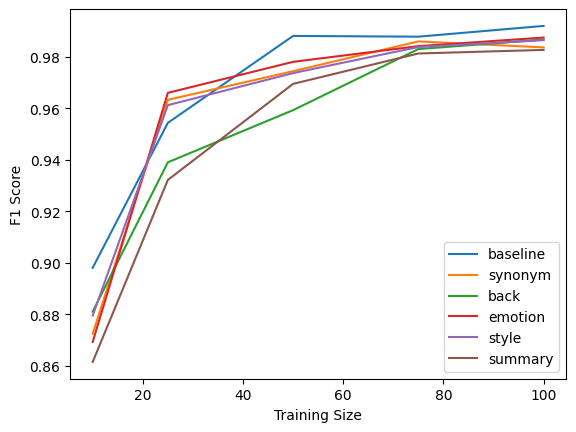

**************** SEED 94 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-div trigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.70it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.8090138746624453

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.73it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.36it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9764292448787177

early stopping.
early stopping
**************** SEED 95 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.98it/s]


Iteration 0, Current Score: 0,                 Best Feature: ada-logprobs v-sub davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 229.42it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.818707902476046

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.15it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-sub ada-logprobs v-> davinci-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.43it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9843618631242643

early stopping.
early stopping
**************** SEED 96 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.32it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 232.98it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9883603238866396

early stopping.
early stopping
**************** SEED 97 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 265.27it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 238.62it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.6836723474436504

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.19it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 223.17it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 25
F1-Score: 0.9403037179263397

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.23it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.46it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 50
F1-Score: 0.9880579317354112

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.89it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.17it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 75
F1-Score: 0.9822789144765003

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.63it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-div ada-logprobs v-> davinci-logprobs s-avg, New Score: 0.99


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.19it/s]


Iteration 1, Current Score: 0.99,                 Best Feature: davinci-logprobs v-div trigram-logprobs s-avg-top-25, New Score: 1.0


100%|███████████████████████████████████████████████████| 2532/2532 [00:12<00:00, 209.18it/s]

Iteration 2, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 100
F1-Score: 0.9915708812260536

passes...
***************** AUGMENTATION: synonym *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 267.82it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 237.35it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 10
F1-Score: 0.6640633716389601

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.21it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.97it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 25
F1-Score: 0.9338652482269504

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.30it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.60it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 50
F1-Score: 0.9853741496598639

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.08it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.34it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 75
F1-Score: 0.9773685569228121

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.95it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.95it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH synonym AUGMENTED DATA.
Train size: 100
F1-Score: 0.9276488122120856

passes...
***************** AUGMENTATION: back *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.25it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 238.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 10
F1-Score: 0.6606263982102908

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 268.10it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.10it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 25
F1-Score: 0.9223875246459939

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 216.30it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 50
F1-Score: 0.9835450592548385

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 207.10it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 75
F1-Score: 0.968391802709274

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 256.44it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 206.01it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH back AUGMENTED DATA.
Train size: 100
F1-Score: 0.9217785843920145

passes...
***************** AUGMENTATION: emotion *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.66it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 239.72it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 10
F1-Score: 0.6523305561810403

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 269.01it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.92it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 25
F1-Score: 0.9146473779385171

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.87it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 218.41it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 50
F1-Score: 0.9835618771825227

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.06it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 210.55it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 75
F1-Score: 0.9748813120414329

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.67it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.77it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH emotion AUGMENTED DATA.
Train size: 100
F1-Score: 0.9395673162882174

passes...
***************** AUGMENTATION: style *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 270.97it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 240.57it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 10
F1-Score: 0.6514195583596214

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.04it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 224.72it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 25
F1-Score: 0.9176428185258605

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 258.55it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 217.38it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 50
F1-Score: 0.9834668484745185

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 261.40it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 211.80it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 75
F1-Score: 0.9747043080376414

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 255.99it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 205.39it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH style AUGMENTED DATA.
Train size: 100
F1-Score: 0.9427807486631016

passes...
***************** AUGMENTATION: summary *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 269.46it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs v-div unigram-logprobs s-min, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 240.19it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 10
F1-Score: 0.6675570395102949

passes...
***************** TRAIN SIZE: 25 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 260.86it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 225.62it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-min, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 25
F1-Score: 0.920126069338136

passes...
***************** TRAIN SIZE: 50 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 257.65it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:11<00:00, 219.60it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 50
F1-Score: 0.9750215331610681

passes...
***************** TRAIN SIZE: 75 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 264.37it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 209.83it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 75
F1-Score: 0.9661179339778765

passes...
***************** TRAIN SIZE: 100 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 259.33it/s]


Iteration 0, Current Score: 0,                 Best Feature: unigram-logprobs v-> ada-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:12<00:00, 204.41it/s]


Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-len, New Score: 1.0
TRAINING WITH summary AUGMENTED DATA.
Train size: 100
F1-Score: 0.935449166218397

passes...


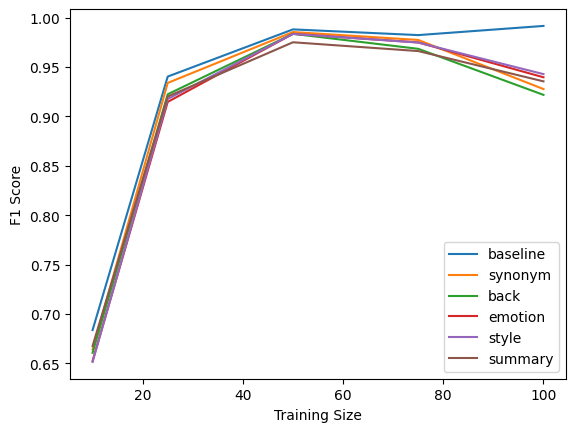

**************** SEED 98 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 266.79it/s]


Iteration 0, Current Score: 0,                 Best Feature: davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 233.87it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9692515627639804

early stopping.
early stopping
**************** SEED 99 ****************
***************** AUGMENTATION: baseline *****************


  0%|          | 0/5 [00:00<?, ?it/s]

***************** TRAIN SIZE: 10 *****************


100%|███████████████████████████████████████████████████| 2534/2534 [00:09<00:00, 271.16it/s]


Iteration 0, Current Score: 0,                 Best Feature: trigram-logprobs v-> davinci-logprobs s-avg, New Score: 1.0


100%|███████████████████████████████████████████████████| 2533/2533 [00:10<00:00, 231.83it/s]

Iteration 1, Current Score: 1.0,                 Best Feature: davinci-logprobs s-max, New Score: 1.0
TRAINING WITHOUT AUGMENTATIONS
Train size: 10
F1-Score: 0.9908395663501135

early stopping.
early stopping


In [13]:
for seed in seeds:
    early_stop = False
    print(f"**************** SEED {seed} ****************")
    for aug in augmentations:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        scores = []
        if early_stop:
            print("early stopping")
            break
        print(f"***************** AUGMENTATION: {aug} *****************")
        for size in tqdm(train_sizes):
            print(f"***************** TRAIN SIZE: {size} *****************")
            train_indices, test_indices, _, _ = train_test_split(
                np.arange(len(train_files)),
                train_labels,
                train_size = size,
                stratify = train_labels
            )
            
            all_test_indices = np.concatenate((test_indices, other_test_indices))
        
            curr_best_features = select_features(
                exp_to_data,
                train_labels,
                verbose=True,
                to_normalize = True,
                indices = train_indices
            )
        
            data = normalize(get_featurized_data(curr_best_features))
            model = LogisticRegression()
            
            if aug != "baseline":
                print(f"TRAINING WITH {aug} AUGMENTED DATA.")
                t_data_aug = pickle.load(open(f"t_data_{aug}", "rb"))
                exp_to_data_aug = pickle.load(open(f"symbolic_data_{aug}", "rb"))
                
                aug_data = normalize(get_featurized_aug(curr_best_features, t_data_aug, exp_to_data_aug))
                aug_indices = np.random.choice(train_indices, size = int(len(train_indices) * config.p))
                
                y = np.concatenate((all_labels[train_indices], all_labels[aug_indices])) # Duplicate training labels
                X = np.concatenate((data[train_indices], aug_data[aug_indices])) # Appending augmented data to original data
            else:
                print("TRAINING WITHOUT AUGMENTATIONS")
                y = all_labels[train_indices]
                X = data[train_indices]
        
            model.fit(X, y)
            
            score = f1_score(all_labels[all_test_indices], model.predict(data[all_test_indices]))
            
            print(f"Train size: {size}")
            print(f"F1-Score: {score}")
            print()
            if aug == "baseline" and ((size == 10 and score > 0.91) or (size == 25 and score > 0.96)):
                print("early stopping.")
                early_stop = True
                break
            else:
                print("passes...")
            scores.append(score)
    
        score_dict[aug] = scores
        
    if not early_stop:
        if not os.path.exists(f"experiments/{seed}"):
            os.makedirs(f"experiments/{seed}")
            
        for experiment, values in score_dict.items():
            plt.plot(train_sizes, values, label = experiment)
        
        plt.legend()
        plt.xlabel("Training Size")
        plt.ylabel("F1 Score")
        plt.savefig(f"experiments/{seed}/results.png")
        plt.show()
    
        with open(f'experiments/{seed}/results.pickle', 'wb') as handle:
            pickle.dump(score_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)